# Huggingface Sagemaker-sdk - Getting Started Demo
### Binary Classification with `Trainer` and `imdb` dataset

1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [Development environment](#Development-environment)  
    3. [Permissions](#Permissions)
3. [Processing](#Preprocessing)   
    1. [Tokenization](#Tokenization)  
    2. [Uploading data to sagemaker_session_bucket](#Uploading-data-to-sagemaker_session_bucket)  
4. [Fine-tuning & starting Sagemaker Training Job](#Fine-tuning-\&-starting-Sagemaker-Training-Job)  
    1. [Creating an Estimator and start a training job](#Creating-an-Estimator-and-start-a-training-job)  
    2. [Estimator Parameters](#Estimator-Parameters)   
    3. [Download fine-tuned model from s3](#Download-fine-tuned-model-from-s3)
    3. [Attach to old training job to an estimator ](#Attach-to-old-training-job-to-an-estimator)  
5. [_Coming soon_:Push model to the Hugging Face hub](#Push-model-to-the-Hugging-Face-hub)

# Development Environment and Permissions 

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [2]:
!pip install "sagemaker>=2.48.0" "transformers==4.6.1" "datasets[s3]==1.6.2" --upgrade

     |████████████████████████████████| 513 kB 30.9 MB/s            
  Preparing metadata (setup.py) ... done
  Using cached transformers-4.6.1-py3-none-any.whl (2.2 MB)
  Using cached datasets-1.6.2-py3-none-any.whl (221 kB)
  Using cached regex-2022.1.18-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (748 kB)
  Using cached tokenizers-0.10.3-cp36-cp36m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Using cached sacremoses-0.0.47-py2.py3-none-any.whl (895 kB)
  Using cached huggingface_hub-0.0.8-py3-none-any.whl (34 kB)
  Using cached tqdm-4.49.0-py2.py3-none-any.whl (69 kB)
     |████████████████████████████████| 211 kB 79.1 MB/s            
  Using cached botocore-1.19.52-py2.py3-none-any.whl (7.2 MB)
  Using cached boto3-1.16.43-py2.py3-none-any.whl (130 kB)
  Using cached s3transfer-0.3.7-py2.py3-none-any.whl (73 kB)
  Using cached attrs-20.3.0-py2.py3-none-any.whl (49 kB)
  Using cached sagemaker-2.77.0.tar.gz (513 kB)


## Development environment 

**upgrade ipywidgets for `datasets` library and restart kernel, only needed when prerpocessing is done in the notebook**

In [3]:
%%capture
import IPython
import sys
!{sys.executable} -m pip install ipywidgets


In [4]:
IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used"

{'status': 'ok', 'restart': True}

In [ ]:
import sagemaker.huggingface

## Permissions

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [2]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::647333706880:role/service-role/AmazonSageMaker-ExecutionRole-20210125T093214
sagemaker bucket: sagemaker-us-east-1-647333706880
sagemaker session region: us-east-1


# ss Use hf sagemaker notebook 01_getting starting processing

In [9]:
from datasets import load_dataset
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# dataset used
#dataset_name = 'imdb'
dataset_name = 'emotion'

# s3 key prefix for the data
s3_prefix = 'samples/datasets/emotion'

In [10]:
# load dataset 
dataset = load_dataset(dataset_name)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, validation_dataset,test_dataset = load_dataset(dataset_name, split=['train', 'validation','test'])
test_dataset = test_dataset.shuffle().select(range(2000)) # smaller the size for test dataset to 10k 


# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
validation_dataset = validation_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset = validation_dataset.rename_column("label", "labels")
validation_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681)
Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681)


In [11]:
train_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'text'],
    num_rows: 16000
})

## Uploading data to `sagemaker_session_bucket`

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [12]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()  

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)

# save validation to s3
validation_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/validation'
validation_dataset.save_to_disk(test_input_path,fs=s3)

In [79]:
[training_input_path,test_input_path,validation_input_path]

['s3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/train',
 's3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/test',
 's3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/validation']

# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator we define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....



```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            transformers_version='4.4',
                            pytorch_version='1.6',
                            py_version='py36',
                            role=role,
                            hyperparameters = {'epochs': 1,
                                               'train_batch_size': 32,
                                               'model_name':'distilbert-base-uncased'
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required ec2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running. 

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. 

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run your training job locally you can define `instance_type='local'` or `instance_type='local_gpu'` for gpu usage. _Note: this does not working within SageMaker Studio_


In [41]:
# !pygmentize ./scripts/train.py
!pygmentize ./scripts/train_multiclass.py

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_from_disk
import random
import logging
import sys
import argparse
import os
import torch

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_argument("--output_data_dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"])
    parser.add_argument("--mod

## Creating an Estimator and start a training job

In [42]:
#ss see next cell with metrics added
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 1,
                 'train_batch_size': 32,
                 'model_name':'distilbert-base-uncased'
                 }

In [14]:
# ss add metrics from ch06
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 3,
             'train_batch_size': 32,
            'checkpoints': '/opt/ml/checkpoints/',
             'model_name':'distilbert-base-uncased'
             }

In [15]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

In [16]:
huggingface_estimator = HuggingFace(entry_point='train_multiclass.py',
                        source_dir='./scripts',
                        instance_type='ml.p3.2xlarge',
                        instance_count=1,
                        role=role,
                        transformers_version='4.6',
                        pytorch_version='1.7',
                        py_version='py36',
                        hyperparameters = hyperparameters,
                        metric_definitions=metric_definitions)

In [44]:
[training_input_path, test_input_path]

['s3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/train',
 's3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/test']

In [60]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

2022-02-24 17:14:12 Starting - Starting the training job...ProfilerReport-1645722852: InProgress
...
2022-02-24 17:14:50 Starting - Preparing the instances for training......
2022-02-24 17:16:09 Downloading - Downloading input data...
2022-02-24 17:16:29 Training - Downloading the training image..................
2022-02-24 17:19:39 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-24 17:19:43,560 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-24 17:19:43,587 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-24 17:19:43,598 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-24 17:19:44,031 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_inp

## Accessing Training Metrics

The training job doesn't emit metrics immediately. For example, it first needs to provision a training instance, download the training image, download the data. Additionally in this demo the first evaluation logs come after 500 steps (default in the Hugging Face trainer https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments).

Hence, **run the below section 15 to 20 minutes after launching the training, otherwise it may not have available metrics yet and return an error**

Note that you can also copy this code and run it from a different place (as long as connected to the cloud and authorized to use the API), by specifiying the exact training job name in the `TrainingJobAnalytics` API call.)

In [82]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=huggingface_estimator.latest_training_job.name).dataframe()
df.head(90)

,timestamp,metric_name,value
0,0.0,loss,0.794000
1,300.0,loss,0.173600
2,600.0,loss,0.094300
3,0.0,learning_rate,0.000050
4,300.0,learning_rate,2.500000
5,600.0,learning_rate,0.000000
6,0.0,eval_loss,0.235926
7,300.0,eval_loss,0.139435
8,600.0,eval_loss,0.139923
9,0.0,eval_accuracy,0.923000


In [81]:
df.size

90

We can also plot some of the metrics collected

*Note: the plot below were generated at the end of the training job, with metrics available for all training duration*

In [83]:
!pip install seaborn

     |████████████████████████████████| 292 kB 26.6 MB/s eta 0:00:01


In [84]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15,5]

<AxesSubplot:label='0513a05b-3938-4188-b520-8695ff8ee0cb', xlabel='timestamp', ylabel='value'>

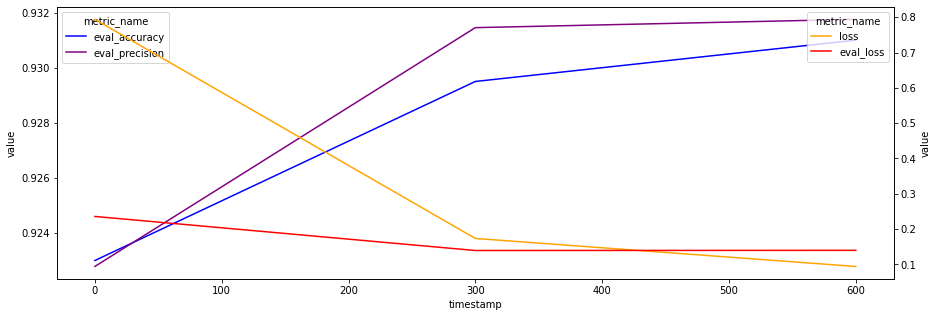

In [85]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    hue='metric_name', 
    palette=['blue', 'purple'])

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name', 
    palette=['orange', 'red'],
    ax=ax2)

## ss after train

In [47]:
huggingface_estimator.output_path

's3://sagemaker-us-east-1-647333706880/'

## Deploying the endpoint

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [86]:
predictor = huggingface_estimator.deploy(1,"ml.g4dn.xlarge")

-------!

## ss start delploy model from S3 https://bit.ly/3vrt0qD

In [18]:
from sagemaker.huggingface import HuggingFaceModel
import sagemaker 

role = sagemaker.get_execution_role()



In [21]:
# create Hugging Face Model Class

huggingface_model = HuggingFaceModel(
   model_data="s3://sagemaker-us-east-1-647333706880/huggingface-pytorch-training-2022-02-24-17-14-11-872/output/model.tar.gz",  # path to your trained sagemaker model
   role=role, # iam role with permissions to create an Endpoint
   transformers_version="4.6", # transformers version used
   pytorch_version="1.7", # pytorch version used
   py_version="py36", # python version of the DLC
)

In [22]:
# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
   initial_instance_count=1,
   instance_type="ml.m5.xlarge"
)

-----!

## ss end delploy model from S3 https://bit.ly/3vrt0qD

In [256]:
def val_label_int2str(row):
    return validation_dataset.features["labels"].int2str(row)


In [249]:
validation_dataset.features["labels"]

ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)

In [257]:
validation_dataset.set_format(type="pandas")
df = validation_dataset[:]


df["label_name"] = df["labels"].apply(val_label_int2str)
df.head()

,attention_mask,input_ids,labels,text,label_name
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 10047, 3110, 3243, 6517, 1998, 3374, 200...",0,im feeling quite sad and sorry for myself but ...,sadness
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2514, 2066, 1045, 2572, 2145, 2559...",0,i feel like i am still looking at a blank canv...,sadness
2,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[101, 1045, 2514, 2066, 1037, 11633, 7947, 102...",2,i feel like a faithful servant,love
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[101, 1045, 2572, 2074, 3110, 27987, 2100, 199...",3,i am just feeling cranky and blue,anger
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2064, 2031, 2005, 1037, 7438, 2030...",1,i can have for a treat or if i am feeling festive,joy


In [188]:
sentiment_input= {"inputs":validation_dataset["text"]}
preds =predictor.predict(sentiment_input)
preds

[{'label': 'LABEL_0', 'score': 0.9990556836128235},
 {'label': 'LABEL_0', 'score': 0.9990630745887756},
 {'label': 'LABEL_2', 'score': 0.6584126949310303},
 {'label': 'LABEL_3', 'score': 0.9984071850776672},
 {'label': 'LABEL_1', 'score': 0.9991805553436279},
 {'label': 'LABEL_1', 'score': 0.9991349577903748},
 {'label': 'LABEL_1', 'score': 0.999137818813324},
 {'label': 'LABEL_1', 'score': 0.9989481568336487},
 {'label': 'LABEL_1', 'score': 0.9989520311355591},
 {'label': 'LABEL_0', 'score': 0.9990861415863037},
 {'label': 'LABEL_3', 'score': 0.9982454180717468},
 {'label': 'LABEL_1', 'score': 0.9992004036903381},
 {'label': 'LABEL_0', 'score': 0.9972246885299683},
 {'label': 'LABEL_0', 'score': 0.9991117715835571},
 {'label': 'LABEL_0', 'score': 0.9987110495567322},
 {'label': 'LABEL_1', 'score': 0.9991365671157837},
 {'label': 'LABEL_0', 'score': 0.9988869428634644},
 {'label': 'LABEL_0', 'score': 0.8399208188056946},
 {'label': 'LABEL_2', 'score': 0.9962166547775269},
 {'label': 'L

In [189]:
pred_df = pd.DataFrame.from_dict(preds)

In [233]:
int(pred_df.label.unique()[0][-1])

0

In [242]:
def pred_int(row):
#    return row
    return int(row[-1])

In [244]:
pred_df['pred_label_num']=pred_df["label"].apply(pred_int)

In [259]:
pred_df['pred_label_label'] = pred_df['pred_label_num'].apply(val_label_int2str)

In [270]:
pred_df['val_label_num'] = df.labels
pred_df['val_label_label']= df.label_name

In [272]:
pred_df

,label,score,pred_label_num,pred_label_label,val_label_num,val_label_label
0,LABEL_0,0.999056,0,sadness,0,sadness
1,LABEL_0,0.999063,0,sadness,0,sadness
2,LABEL_2,0.658413,2,love,2,love
3,LABEL_3,0.998407,3,anger,3,anger
4,LABEL_1,0.999181,1,joy,1,joy
...,...,...,...,...,...,...
1995,LABEL_0,0.998145,0,sadness,0,sadness
1996,LABEL_1,0.999023,1,joy,1,joy
1997,LABEL_1,0.999189,1,joy,1,joy
1998,LABEL_1,0.504896,1,joy,1,joy


In [277]:
pred_df[(pred_df.pred_label_num != pred_df.val_label_num)]

,label,score,pred_label_num,pred_label_label,val_label_num,val_label_label
17,LABEL_0,0.839921,0,sadness,3,anger
27,LABEL_2,0.714907,2,love,1,joy
35,LABEL_2,0.652078,2,love,1,joy
83,LABEL_3,0.619488,3,anger,0,sadness
91,LABEL_2,0.549718,2,love,1,joy
...,...,...,...,...,...,...
1963,LABEL_2,0.444590,2,love,1,joy
1975,LABEL_4,0.572352,4,fear,0,sadness
1981,LABEL_5,0.539767,5,surprise,4,fear
1990,LABEL_5,0.517822,5,surprise,4,fear


In [278]:
pred_df[(pred_df.pred_label_num == pred_df.val_label_num)]

,label,score,pred_label_num,pred_label_label,val_label_num,val_label_label
0,LABEL_0,0.999056,0,sadness,0,sadness
1,LABEL_0,0.999063,0,sadness,0,sadness
2,LABEL_2,0.658413,2,love,2,love
3,LABEL_3,0.998407,3,anger,3,anger
4,LABEL_1,0.999181,1,joy,1,joy
...,...,...,...,...,...,...
1995,LABEL_0,0.998145,0,sadness,0,sadness
1996,LABEL_1,0.999023,1,joy,1,joy
1997,LABEL_1,0.999189,1,joy,1,joy
1998,LABEL_1,0.504896,1,joy,1,joy


In [246]:
pred_df.columns

Index(['label', 'score', 'pred_label_num'], dtype='object')

In [269]:
df.head()

,attention_mask,input_ids,labels,text,label_name
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 10047, 3110, 3243, 6517, 1998, 3374, 200...",0,im feeling quite sad and sorry for myself but ...,sadness
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2514, 2066, 1045, 2572, 2145, 2559...",0,i feel like i am still looking at a blank canv...,sadness
2,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[101, 1045, 2514, 2066, 1037, 11633, 7947, 102...",2,i feel like a faithful servant,love
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[101, 1045, 2572, 2074, 3110, 27987, 2100, 199...",3,i am just feeling cranky and blue,anger
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2064, 2031, 2005, 1037, 7438, 2030...",1,i can have for a treat or if i am feeling festive,joy


In [190]:
predictor.delete_endpoint()

## multiclass confus

In [102]:
prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features.data, 100)]

TypeError: Object of type 'Tensor' is not JSON serializable

In [97]:
#ss pytorch
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].data[0]
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))

In [88]:
#ss this seems to be written for tensorflow..see above for pytorch
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))

In [91]:
[validation_dataset['labels'][:5],validation_dataset['input_ids'][:5]]

[tensor([0, 0, 2, 3, 1]),
 tensor([[  101, 10047,  3110,  ...,     0,     0,     0],
         [  101,  1045,  2514,  ...,     0,     0,     0],
         [  101,  1045,  2514,  ...,     0,     0,     0],
         [  101,  1045,  2572,  ...,     0,     0,     0],
         [  101,  1045,  2064,  ...,     0,     0,     0]])]

In [92]:
test_features=validation_dataset['labels']
test_labels=validation_dataset['input_ids']

In [95]:
import numpy as np

In [98]:
evaluate_metrics(predictor, test_features, test_labels)

TypeError: Object of type 'Tensor' is not JSON serializable

## end multiclass confusion matrix see https://go.aws/354gFhm

# ss end Use hf sagemaker notebook 01_getting starting processing

# Start NLPwTransformers  Chp2 Scott

In [3]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 3121 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [4]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681)


In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,label,text
0,0,i didnt feel humiliated
1,0,i can go from feeling so hopeless to so damned...
2,3,im grabbing a minute to post i feel greedy wrong
3,2,i am ever feeling nostalgic about the fireplac...
4,3,i am feeling grouchy


In [7]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,label,text,label_name
0,0,i didnt feel humiliated,sadness
1,0,i can go from feeling so hopeless to so damned...,sadness
2,3,im grabbing a minute to post i feel greedy wrong,anger
3,2,i am ever feeling nostalgic about the fireplac...,love
4,3,i am feeling grouchy,anger


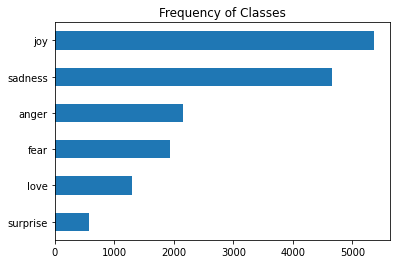

In [8]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

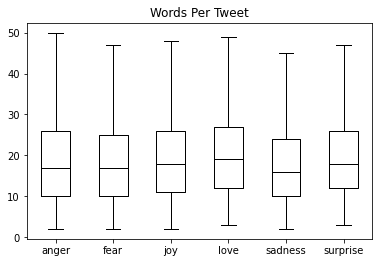

In [9]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [10]:
emotions.reset_format()

## jump to fine-tune

In [11]:
import torch
import torch.nn.functional as F

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
# hide_output
from transformers import AutoModelForSequenceClassification
model_ckpt = "distilbert-base-uncased"

num_labels = 6


In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [19]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [29]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [32]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [33]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

TypeError: __init__() got an unexpected keyword argument 'log_level'

# End NLPwTransformers Chp2 Scott

# Preprocessing

We are using the `datasets` library to download and preprocess the `imdb` dataset. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job. The [imdb](http://ai.stanford.edu/~amaas/data/sentiment/) dataset consists of 25000 training and 25000 testing highly polar movie reviews.

## Tokenization 

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# dataset used
dataset_name = 'imdb'

# s3 key prefix for the data
s3_prefix = 'hf-samples/datasets/imdb'

In [6]:
#ss
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

In [7]:
#ss
# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

In [10]:
# this took >30min
# load dataset
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/4ea52f2e58a08dbc12c2bd52d0d92b30b88c00230b4522801b3636782f625c5b. Subsequent calls will reuse this data.


In [35]:
#ss see https://bit.ly/3JCImg4
train_dataset.features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'labels': ClassLabel(num_classes=2, names=['neg', 'pos'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

In [36]:
train_dataset["text"][:5]

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
 'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything fro

In [37]:
train_dataset.set_format(type="pandas")
df = train_dataset[:]
df.head()

,attention_mask,input_ids,labels,text
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 22953, 2213, 4381, 2152, 2003, 1037, 947...",1,Bromwell High is a cartoon comedy. It ran at t...
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 11573, 2791, 1006, 2030, 2160, 24913, 20...",1,Homelessness (or Houselessness as George Carli...
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 8235, 2058, 1011, 3772, 2011, 23920, 575...",1,Brilliant over-acting by Lesley Ann Warren. Be...
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2023, 2003, 4089, 1996, 2087, 2104, 9250...",1,This is easily the most underrated film inn th...
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2023, 2003, 2025, 1996, 5171, 11463, 837...",1,This is not the typical Mel Brooks film. It wa...


In [248]:
train_dataset.features["labels"]

ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)

In [43]:
def label_int2str(row):
    return train_dataset.features["labels"].int2str(row)

df["label_name"] = df["labels"].apply(label_int2str)
df.head()

,attention_mask,input_ids,labels,text,label_name
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 22953, 2213, 4381, 2152, 2003, 1037, 947...",1,Bromwell High is a cartoon comedy. It ran at t...,pos
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 11573, 2791, 1006, 2030, 2160, 24913, 20...",1,Homelessness (or Houselessness as George Carli...,pos
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 8235, 2058, 1011, 3772, 2011, 23920, 575...",1,Brilliant over-acting by Lesley Ann Warren. Be...,pos
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2023, 2003, 4089, 1996, 2087, 2104, 9250...",1,This is easily the most underrated film inn th...,pos
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2023, 2003, 2025, 1996, 5171, 11463, 837...",1,This is not the typical Mel Brooks film. It wa...,pos


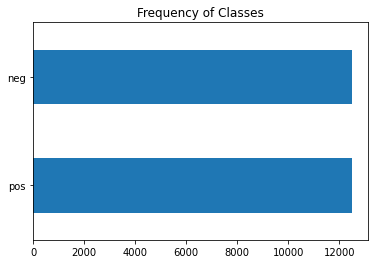

In [44]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

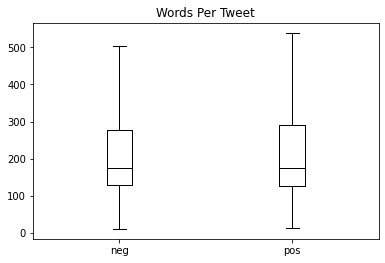

In [45]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [47]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [11]:
test_dataset = test_dataset.shuffle().select(range(10000)) # smaller the size for test dataset to 10k 

In [12]:
# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)


In [13]:
test_dataset = test_dataset.map(tokenize, batched=True)

In [49]:
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])


In [48]:
# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

ValueError: Original column name label not in the dataset. Current columns in the dataset: ['attention_mask', 'input_ids', 'labels', 'text']

In [4]:
#ss break apart
# NonMatchingSplitsSizesError
# load dataset
# dataset = load_dataset(dataset_name)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
test_dataset = test_dataset.shuffle().select(range(10000)) # smaller the size for test dataset to 10k 


# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

NonMatchingSplitsSizesError: [{'expected': SplitInfo(name='train', num_bytes=33442202, num_examples=25000, dataset_name='imdb'), 'recorded': SplitInfo(name='train', num_bytes=14652463, num_examples=11149, dataset_name='imdb')}, {'expected': SplitInfo(name='unsupervised', num_bytes=67125548, num_examples=50000, dataset_name='imdb'), 'recorded': SplitInfo(name='unsupervised', num_bytes=0, num_examples=0, dataset_name='imdb')}]

In [4]:
# load dataset
dataset = load_dataset(dataset_name)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
test_dataset = test_dataset.shuffle().select(range(10000)) # smaller the size for test dataset to 10k 


# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

NonMatchingSplitsSizesError: [{'expected': SplitInfo(name='train', num_bytes=33442202, num_examples=25000, dataset_name='imdb'), 'recorded': SplitInfo(name='train', num_bytes=14652463, num_examples=11149, dataset_name='imdb')}, {'expected': SplitInfo(name='unsupervised', num_bytes=67125548, num_examples=50000, dataset_name='imdb'), 'recorded': SplitInfo(name='unsupervised', num_bytes=0, num_examples=0, dataset_name='imdb')}]

## Uploading data to `sagemaker_session_bucket`

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [15]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()  

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)


# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator we define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....



```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            transformers_version='4.4',
                            pytorch_version='1.6',
                            py_version='py36',
                            role=role,
                            hyperparameters = {'epochs': 1,
                                               'train_batch_size': 32,
                                               'model_name':'distilbert-base-uncased'
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required ec2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running. 

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. 

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run your training job locally you can define `instance_type='local'` or `instance_type='local_gpu'` for gpu usage. _Note: this does not working within SageMaker Studio_


In [50]:
#ss
text ="I dont give two fucks"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2123, 2102, 2507, 2048, 6616, 2015, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [51]:
#ss
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'don', '##t', 'give', 'two', 'fuck', '##s', '[SEP]']


In [54]:
#ss
print(tokenizer.convert_tokens_to_string(tokens))
tokenizer.model_input_names

[CLS] i dont give two fucks [SEP]


['input_ids', 'attention_mask']

In [53]:
#ss
tokenizer.vocab_size

30522

In [62]:
import os
import pprint
  
# Get the list of user's
# environment variables
env_var = os.environ
  
# Print the list of user's
# environment variables
print("User's Environment variable:")
pprint.pprint(dict(env_var), width = 1)

User's Environment variable:
{'AWS_ACCOUNT_ID': '647333706880',
 'AWS_CONTAINER_CREDENTIALS_RELATIVE_URI': '/_sagemaker-instance-credentials/7a55a75861996f9b9066e4028202d00380772c0a31fab00632e444b2f6716bcd',
 'AWS_DEFAULT_REGION': 'us-east-1',
 'AWS_INTERNAL_IMAGE_OWNER': 'DLC',
 'AWS_REGION': 'us-east-1',
 'AWS_SAGEMAKER_PYTHONNOUSERSITE': '0',
 'CLICOLOR': '1',
 'DGLBACKEND': 'pytorch',
 'GIT_PAGER': 'cat',
 'HOME': '/root',
 'HOSTNAME': 'pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515',
 'JPY_PARENT_PID': '21',
 'JUPYTER_PATH': '/opt/conda/share/jupyter/',
 'KERNEL_GATEWAY': '1',
 'KERNEL_LAUNCH_TIMEOUT': '40',
 'KERNEL_WORKING_PATH': 'HuggingFacenotebooks/sagemaker/ss_01_getting_started_pytorch',
 'KMP_INIT_AT_FORK': 'FALSE',
 'LANG': 'C.UTF-8',
 'LC_ALL': 'C.UTF-8',
 'LD_LIBRARY_PATH': ':/usr/local/lib:/opt/conda/lib:/home/.openmpi/lib/',
 'MPLBACKEND': 'module://ipykernel.pylab.backend_inline',
 'PAGER': 'cat',
 'PATH': '/opt/conda/bin:/usr/local/sbin:/usr/local/b

In [16]:
!pygmentize ./scripts/train.py

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_from_disk
import random
import logging
import sys
import argparse
import os
import torch

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_argument("--output_data_dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"])
    parser.add_argument("--mod

## Creating an Estimator and start a training job

In [17]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 1,
                 'train_batch_size': 32,
                 'model_name':'distilbert-base-uncased'
                 }

In [18]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.6',
                            pytorch_version='1.7',
                            py_version='py36',
                            hyperparameters = hyperparameters)

In [19]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

2022-02-18 00:39:50 Starting - Starting the training job...
2022-02-18 00:39:59 Starting - Launching requested ML instancesProfilerReport-1645144789: InProgress
.........
2022-02-18 00:41:36 Starting - Preparing the instances for training.........
2022-02-18 00:43:17 Downloading - Downloading input data
2022-02-18 00:43:17 Training - Downloading the training image..................
2022-02-18 00:46:21 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-18 00:46:22,223 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-18 00:46:22,246 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-18 00:46:22,257 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-18 00:46:22,806 sagemaker-training-toolkit INFO     Invoking user script
Train

## Deploying the endpoint

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [20]:
predictor = huggingface_estimator.deploy(1,"ml.g4dn.xlarge")

-------!

Then, we use the returned predictor object to call the endpoint.

In [23]:
sentiment_input= {"inputs":"I love using the new Inference DLC."}

predictor.predict(sentiment_input)

[{'label': 'LABEL_1', 'score': 0.9655656814575195}]

Finally, we delete the endpoint again.

In [24]:
predictor.delete_endpoint()

# Extras

### Estimator Parameters

In [22]:
# container image used for training job
print(f"container image used for training job: \n{huggingface_estimator.image_uri}\n")

# s3 uri where the trained model is located
print(f"s3 uri where the trained model is located: \n{huggingface_estimator.model_data}\n")

# latest training job name for this estimator
print(f"latest training job name for this estimator: \n{huggingface_estimator.latest_training_job.name}\n")



container image used for training job: 
None

s3 uri where the trained model is located: 
s3://sagemaker-us-east-1-647333706880/huggingface-pytorch-training-2022-02-18-00-39-49-588/output/model.tar.gz

latest training job name for this estimator: 
huggingface-pytorch-training-2022-02-18-00-39-49-588



In [23]:
# access the logs of the training job
huggingface_estimator.sagemaker_session.logs_for_job(huggingface_estimator.latest_training_job.name)

2022-02-18 00:59:21 Starting - Preparing the instances for training
2022-02-18 00:59:21 Downloading - Downloading input data
2022-02-18 00:59:21 Training - Training image download completed. Training in progress.
2022-02-18 00:59:21 Uploading - Uploading generated training model
2022-02-18 00:59:21 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-18 00:46:22,223 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-18 00:46:22,246 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-18 00:46:22,257 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-18 00:46:22,806 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "train

### Attach to old training job to an estimator 

In Sagemaker you can attach an old training job to an estimator to continue training, get results etc..

In [ ]:
from sagemaker.estimator import Estimator

# job which is going to be attached to the estimator
old_training_job_name=''

In [ ]:
# attach old training job
huggingface_estimator_loaded = Estimator.attach(old_training_job_name)

# get model output s3 from training job
huggingface_estimator_loaded.model_data